# Informações dos dados obtidos.

O conjunto de dados contém 9358 resultados médios de 5 sensores químicos de um dispositivo multisensor (PTXX.SX). O dispositivo estava localizado a nível da rua, dentro de uma cidade significativamente poluída. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano). Valores ausentes são marcados com o valor -200. A medida de outros sensores também está disponível e algumas podem ser redundantes. ***A variável chave a ser analisada é PT08.S1 (CO), concentração de CO na atmosfera.***
Informação das colunas:

1.  Date (DD/MM/YYYY)
2.  Time (HH.MM.SS)
3.  PT08.S1 (CO) – Variável de predição
4.  Non Metanic HydroCarbons Concentration (mg/m^3)
5.  Benzene Concentration (mg/m^3)
6.  PT08.S2 (NMHC)
7.  NOx Concentration (ppb)
8.  PT08.S3 (NOx)
9.  NO2 Concentration (mg/m^3)
10. PT08.S4 (NO2s)
11. PT08.S5 (O3)
12. Temperature (C)
13. Relative Humidity (%)
14. AH Absolute Humidity
15. Dia da Semana	
16. Mês
17. Target_log
18. Target_log_dff_1
19. Target_log_dff_2
20. Target_log_dff_3  
21. Estações_Inverno	
22. Estações_Outono	
23. Estações_Primavera	
24. Estações_Verão

# Objetivo
 
* A parte anterior foi encarregada de encontrar a melhor maneira de codificar as variáveis categóricas. Essa parte agora está encubido de criar algumas variáveis padrões de Time séries para ver se o desempenho do classificador padrão melhora.



# Bibliotecas

In [ ]:
# import pandas as pd
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import statsmodels.tsa.stattools
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_style("whitegrid")
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções

In [ ]:
def MAPE(y_pred,Y_teste):
  return np.mean(100*np.abs(y_pred - Y_teste)/np.abs(Y_teste))


def validation(X,Y,Date):
  Ypred = []
  Yv    = []
  tscv = TimeSeriesSplit(n_splits=10)
  vetor_MAPE = np.zeros(10) 
  i = 0
  for linhas_treino, linhas_valid in tscv.split(X):    
    X_t, X_v = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_t, y_v = Y[linhas_treino], Y[linhas_valid]

    md                    = model.fit(X_t, y_t)
    y_pred                = md.predict(X_v)

    y_pred = 10**y_pred
    y_v    = 10**y_v
    Ypred.append(y_pred)
    Yv.append(y_v)

    mape = MAPE(y_pred,y_v)
    vetor_MAPE[i] = mape
    i = i + 1
    print('Data:',Date[linhas_valid[0]],'-',Date[linhas_valid[-1]], '->', 'MAPE:',np.format_float_positional(mape,5))

  print("\n")
  print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE),5),'Std:',np.format_float_positional(np.std(vetor_MAPE),5),'Erro:',np.format_float_positional(np.std(vetor_MAPE)/np.sqrt(5),5))

  return Ypred,Yv,vetor_MAPE

def sep_dados(d,col):
  X_teste = d[d['Date'] > '2004-12-01']
  X_train = d[d['Date'] <= '2004-12-01']

  Y_teste = d[col][d['Date'] > '2004-12-01']
  Y_train = d[col][d['Date'] <= '2004-12-01']
  
  X_train = X_train.drop(columns = ['Date','Target_log'])
  X_teste = X_teste.drop(columns = ['Date','Target_log'])

  Y_train = Y_train.drop(columns = 'Date')
  Y_teste = Y_teste.drop(columns = 'Date')

  return X_train,X_teste,Y_train,Y_teste



def modelo(model,X_train,Y_train,X_teste,Y_teste):
  # treinado e avaliando o modelo
  md       = model.fit(X_train, Y_train)
  y_pred   = md.predict(X_teste)
  y_pred   = 10**y_pred
  Y_teste  = 10**Y_teste
  resultado = MAPE(y_pred,Y_teste)
  bias      = np.mean(y_pred-Y_teste)
  erro      = np.abs(y_pred-Y_teste)
  return resultado,bias,erro

# Importado os dados

In [ ]:
df = pd.read_csv('/content/drive/My Drive/new_dados3.csv',encoding = "UTF-8")

In [ ]:
df.head()

,Unnamed: 0,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia da Semana,Mês,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3,Estações_Inverno,Estações_Outono,Estações_Primavera,Estações_Verão
0,3,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2,3,3.138618,3.146748,3.111263,3.133539,0,0,1,0
1,4,2004-03-10,22,6.5,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,2,3,3.104487,3.138618,3.146748,3.111263,0,0,1,0
2,5,2004-03-10,23,4.7,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,2,3,3.078094,3.104487,3.138618,3.146748,0,0,1,0
3,6,2004-03-11,0,3.6,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,3,3,3.073718,3.078094,3.104487,3.138618,0,0,1,0
4,7,2004-03-11,1,3.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,3,3,3.055378,3.073718,3.078094,3.104487,0,0,1,0


In [ ]:
Date = df['Date']

In [ ]:
df =df.drop(columns = ['Unnamed: 0']) # Excluido colunas que não estão adicionado informações redundate.

# Variáveis extras

### Valor padrão.

In [ ]:
df1 = df.copy()

In [ ]:
model    = RandomForestRegressor(n_estimators = 100,random_state = 10) # modelo padrão

In [ ]:
X = df.drop(columns = ['Target_log','Date'])
Y = df['Target_log']

In [ ]:
Ypred,Yv,vetor_MAPE = validation(X,Y,Date)

Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.23790
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.59346
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.45366
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.74221
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.51201
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.73439
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.24683
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18521
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.06368
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.10244


Mape Geral: 4.38718 Std: 1.82594 Erro: 0.81658


### Difeça entre os lags

In [ ]:
df2 = df.copy()

In [ ]:
df2['Diff_1'] = df2['Target_log_dff_1'] - df2['Target_log_dff_2']
df2['Diff_2'] = df2['Target_log_dff_2'] - df2['Target_log_dff_3']

In [ ]:
X2 = df2.drop(columns = ['Target_log','Date'])
Y2 = df2['Target_log']

In [ ]:
Ypred2,Yv2,vetor_MAPE2 = validation(X2,Y2,Date)

Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.14542
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.56151
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46756
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.73325
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.49027
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74908
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.20713
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18139
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.0562
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.09082


Mape Geral: 4.36826 Std: 1.80324 Erro: 0.80643


### Média
 



In [ ]:
df3 = df.copy()

In [ ]:
df3['Media'] = (df3['Target_log_dff_1'] + df3['Target_log_dff_2'] + df3['Target_log_dff_3'])/3

In [ ]:
X3 = df3.drop(columns = ['Target_log','Date'])
Y3 = df3['Target_log']

In [ ]:
Ypred3,Yv3,vetor_MAPE3 = validation(X3,Y3,Date)

Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.1728
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.5809
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.45953
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.74629
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.53481
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.75627
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23788
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.17222
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07818
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.09682


Mape Geral: 4.38357 Std: 1.80708 Erro: 0.80815


### Número de lags

In [ ]:
df4 = df.copy()

In [ ]:
df4 = df4.drop(columns=['Target_log_dff_1','Target_log_dff_2','Target_log_dff_3'])

In [ ]:
mape_lag = []
erro_lag = []

In [ ]:
X4 = df4.drop(columns = ['Target_log','Date'])
Y4 = df4['Target_log']
Ypred4,Yv4,vetor_MAPE4 = validation(X4,Y4,Date)
mape_lag.append(np.mean(vetor_MAPE4))
erro_lag.append(np.std(vetor_MAPE4)/np.sqrt(10))

Data: 2004-04-15 - 2004-05-19 -> MAPE: 10.51325
Data: 2004-05-19 - 2004-06-24 -> MAPE: 9.76714
Data: 2004-06-24 - 2004-07-28 -> MAPE: 4.21997
Data: 2004-07-28 - 2004-09-02 -> MAPE: 3.44032
Data: 2004-09-02 - 2004-10-07 -> MAPE: 4.77458
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.51797
Data: 2004-11-10 - 2004-12-14 -> MAPE: 8.12637
Data: 2004-12-14 - 2005-01-22 -> MAPE: 5.75848
Data: 2005-01-22 - 2005-03-01 -> MAPE: 4.03020
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.5188


Mape Geral: 5.76671 Std: 2.56934 Erro: 1.14905


In [ ]:
for i in np.arange(1,7):
  df4['Target_log_dff_' + str(i)] = df4['Target_log'].shift(i)
  df4                             = df4.dropna()
  df4.index = np.arange(df4.shape[0])
  X4_ = df4.drop(columns = ['Target_log','Date'])
  Y4_ = df4['Target_log']
  print('lag_'+str(i))
  Ypred4,Yv4,vetor_MAPE4 = validation(X4_,Y4_,Date)
  mape_lag.append(np.mean(vetor_MAPE4))
  erro_lag.append(np.std(vetor_MAPE4)/np.sqrt(10))
  print('\n')


lag_1
Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.43510
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.62922
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46027
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.69040
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.5968
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.76728
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.29153
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.27332
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.10456
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.07596


Mape Geral: 4.43244 Std: 1.87109 Erro: 0.83678


lag_2
Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.14618
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.64143
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.52311
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.68359
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52416
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74485
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.31114
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.2364
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.04533
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.06126

In [ ]:
#erro_lag

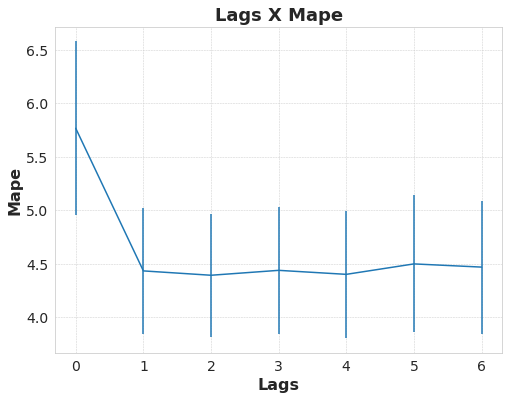

In [ ]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.figure(figsize=(8,6))
plt.errorbar(np.arange(len(mape_lag)),mape_lag,np.array(erro_lag))
plt.title('Lags X Mape', fontsize = 18,fontweight= 'bold')
plt.xlabel('Lags', fontsize= 16, fontweight= 'bold')
plt.ylabel('Mape', fontsize= 16, fontweight= 'bold')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
#mape_lag

# Conclusão:

* Os resultados mostram que o número de lags suficiente para melhorar o desempenho do modelo é de apenas uma Lag. E as outras variáveis que foram adicionadas apresentou uma piora no desempenho do modelo padrão.

In [ ]:
df = df.drop(columns = ['Target_log_dff_2','Target_log_dff_3'])

In [ ]:
df.to_csv('/content/drive/My Drive/new_dados4.csv')